In [227]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
import numpy as np

In [205]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [206]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [207]:
salary = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [208]:
salary.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


In [209]:
salary.tail()

,WAG_C_M
month,
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0
2016-07-01,35888.0
2016-08-01,34095.0


# Визуальный анализ ряда

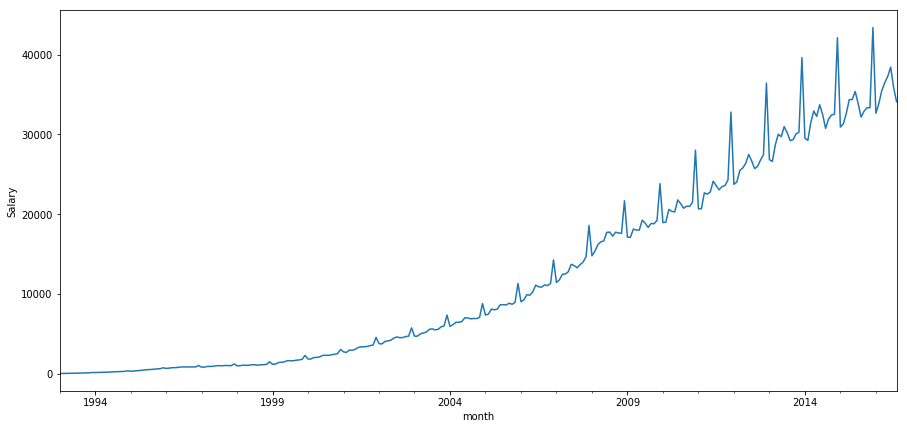

In [210]:
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
plt.ylabel('Salary')
pylab.show()

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

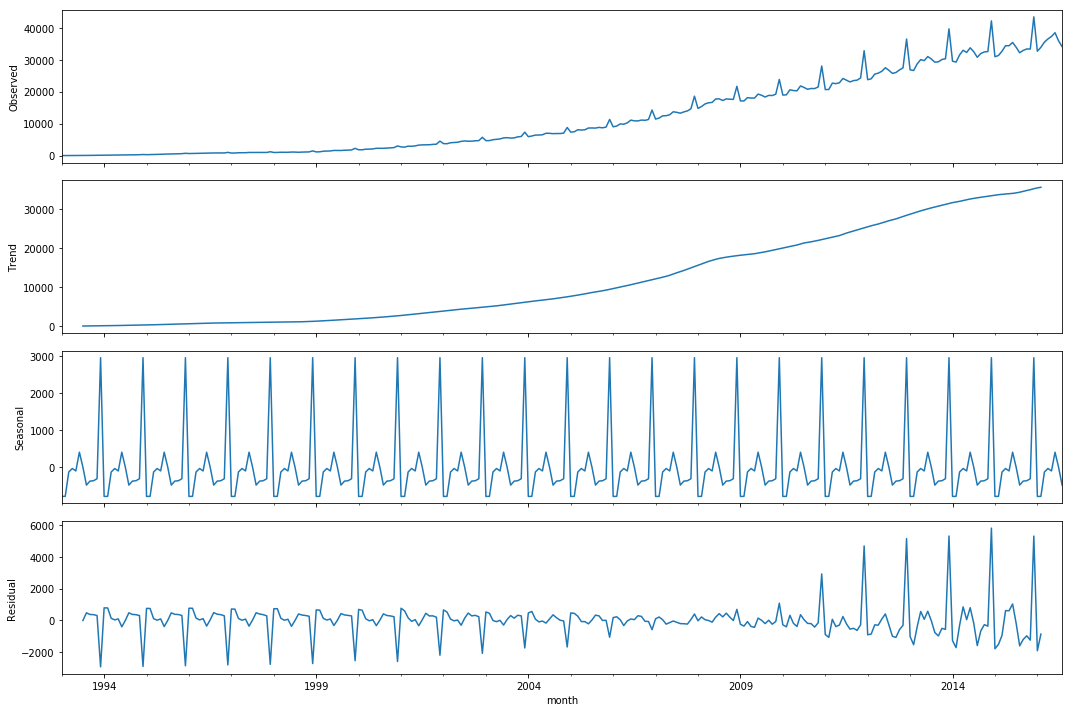

In [211]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M)[1])

# Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


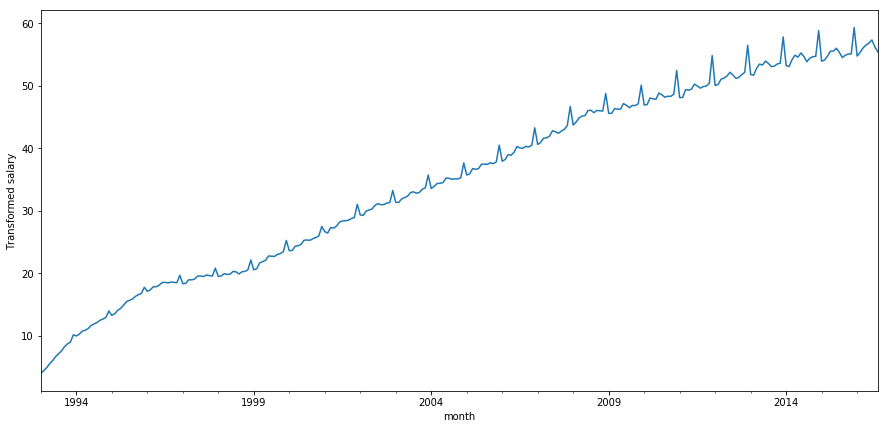

In [212]:
salary['salary_box'], lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize(15,7))
salary.salary_box.plot()
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box)[1])

# Выбор порядка дифференцирования

## Сезонное дифференцирование

In [213]:
salary['salary_box_diff'] = salary.WAG_C_M - salary.WAG_C_M.shift(12)

Критерий Дики-Фуллера: p=0.546315


<Figure size 1080x720 with 0 Axes>

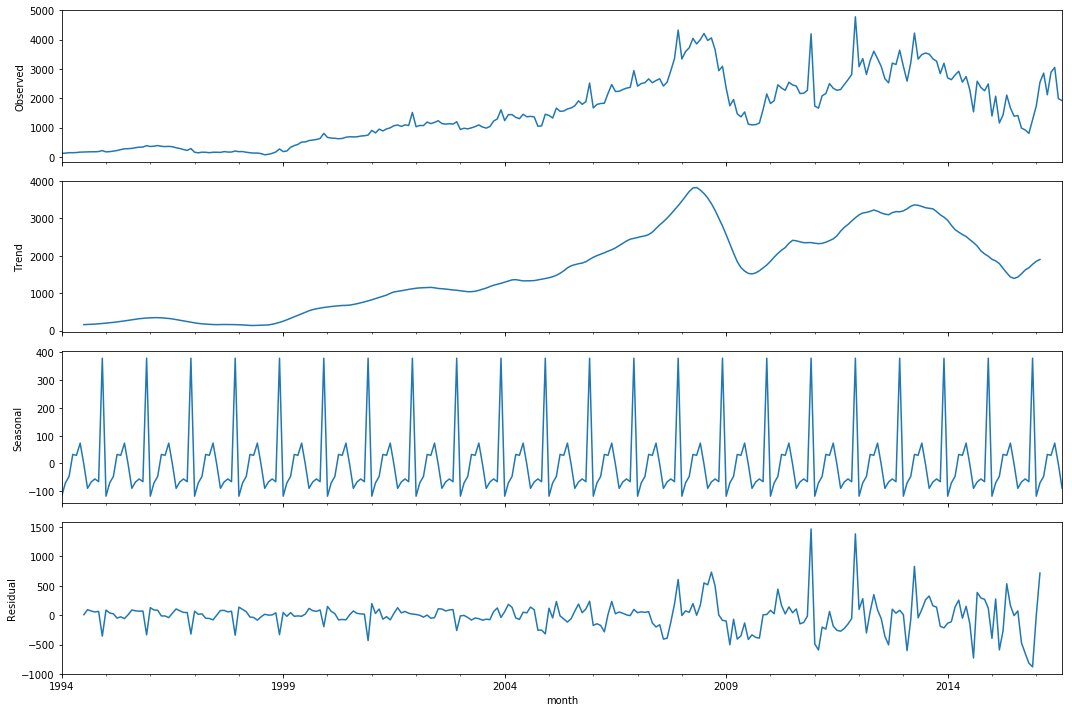

In [214]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff.dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff.dropna())[1])

## Дифференцирование ряда - 1

In [215]:
salary['salary_box_diff1'] = salary.salary_box_diff - salary.salary_box_diff.shift(1)

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

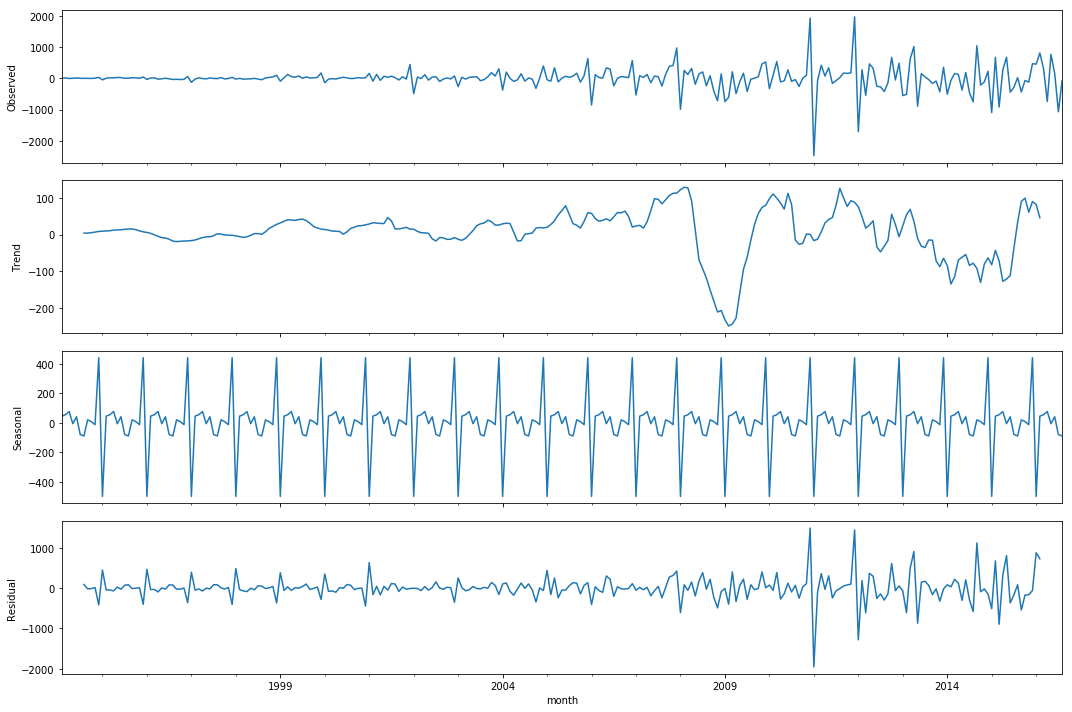

In [216]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff1.dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff1.dropna())[1])

## Дифференцирование ряда - 2

In [217]:
salary['salary_box_diff2'] = salary.salary_box_diff1 - salary.salary_box_diff1.shift(1)

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

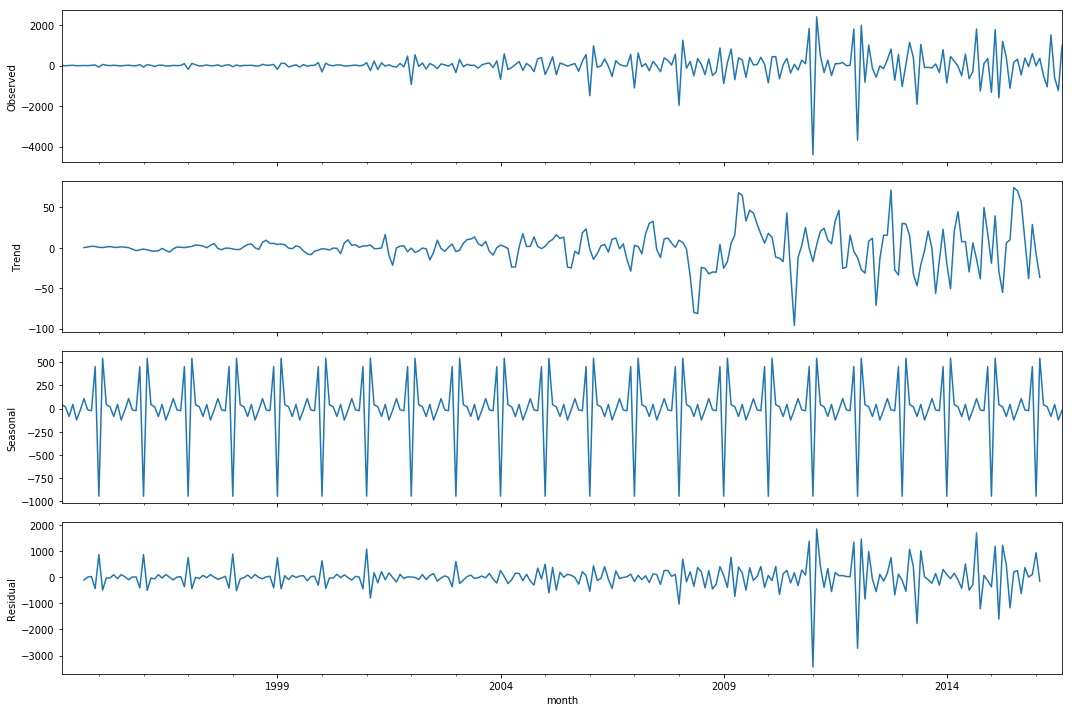

In [218]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff2.dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff2.dropna())[1])

* D = 1
* d = 2

# Выбор начальных приближений для p, q, P, Q

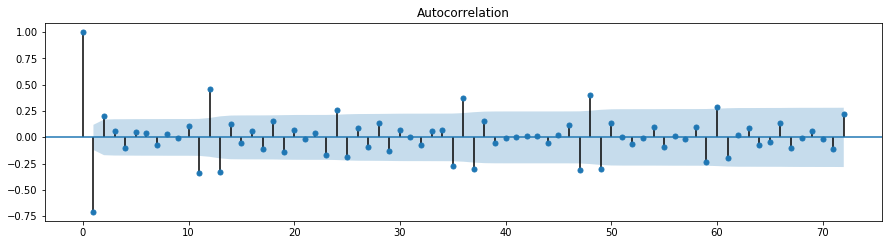

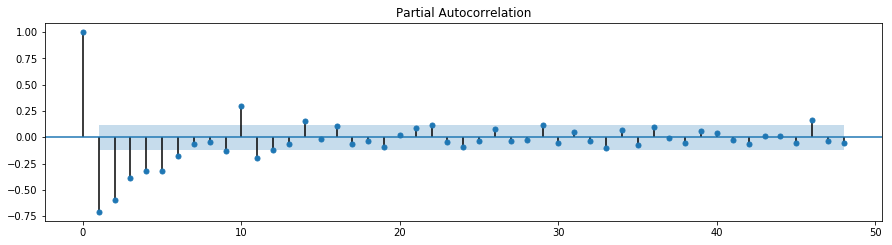

In [224]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.salary_box_diff3.dropna().values.squeeze(), lags=72, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.salary_box_diff3.dropna().values.squeeze(), lags=48, ax=ax)
pylab.show()

* q = 2
* Q = 4
* P = 1
* p = 6

In [228]:
ps = range(0, 7)
d=2
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 5)

In [229]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

210

In [230]:
len(salary.iloc[0:20]) - len(salary.iloc[0:20].dropna())

15

# Обучение и сравнение моделей-кандидатов, выбор победителя

In [231]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 2, 1, 0)
wrong parameters: (0, 2, 1, 1)
wrong parameters: (0, 2, 1, 2)
wrong parameters: (0, 2, 1, 3)
wrong parameters: (0, 2, 1, 4)
Wall time: 20min 28s


In [232]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters       aic
192  (6, 1, 1, 3) -1.719257
193  (6, 1, 1, 4) -1.576800
188  (6, 1, 0, 4) -0.825782
189  (6, 1, 1, 0) -0.609159
163  (5, 1, 1, 4) -0.526294


In [233]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(6, 2, 1)x(1, 1, 3, 12)   Log Likelihood                  12.860
Date:                            Sun, 07 Apr 2019   AIC                             -1.719
Time:                                    00:50:18   BIC                             42.068
Sample:                                01-01-1993   HQIC                            15.836
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1367      0.051     -2.695      0.007      -0.236      -0.037
ar.L2          0.0487      0.070   

# Анализ остатков построенной модели

Критерий Стьюдента: p=0.099233
Критерий Дики-Фуллера: p=0.000000


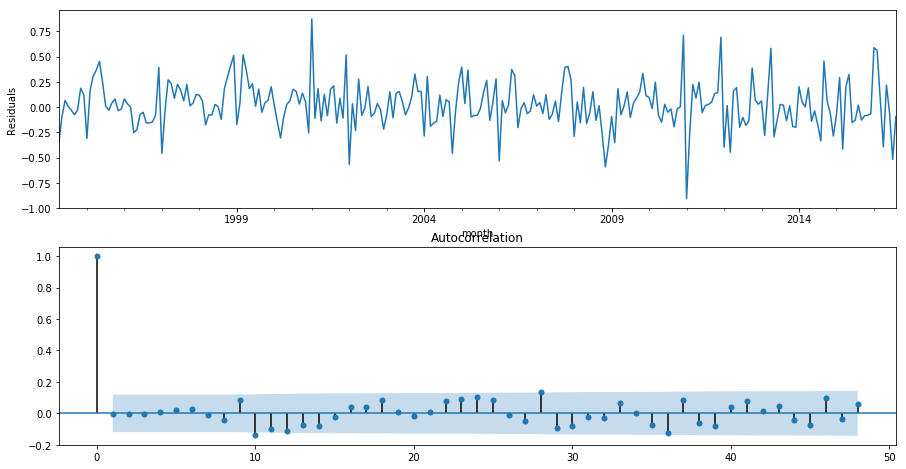

In [234]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[15:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[15:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[15:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[15:])[1])

In [235]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)

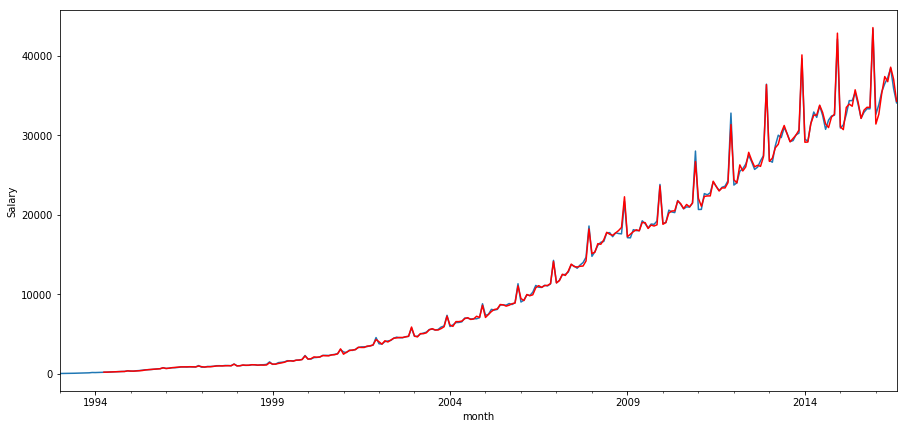

In [236]:
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
#best_model.fittedvalues.plot(color='r')
salary.model[15:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

# Прогнозирование с помощью финальной модели

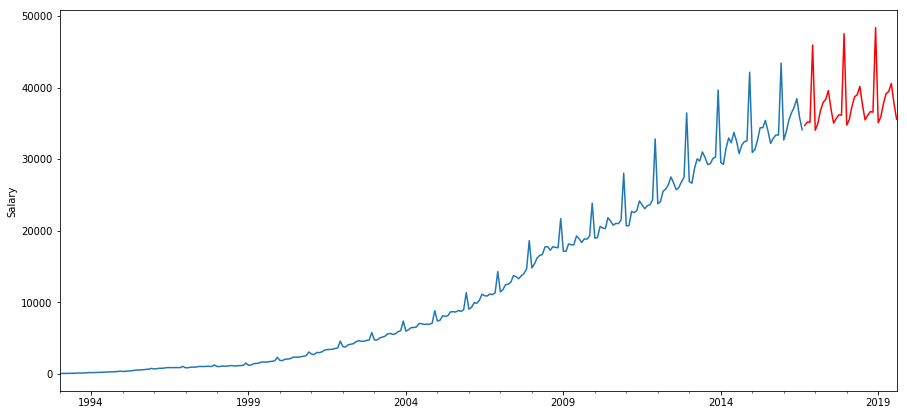

In [237]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=284, end=320), lmbda)

plt.figure(figsize(15,7))
salary2.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()